In [1]:
import pandas as pd

In [2]:
patch_denorm_upstream = pd.read_csv('resources/linux/resources/patch_denorm_upstream.csv')
patch_denorm_responses = pd.read_csv('resources/linux/resources/patch_denorm_responses.csv')
patch_responses = pd.merge(patch_denorm_upstream, patch_denorm_responses, how ='inner', on='idx')\
                    .drop(['patch_id_y', 'idx'], axis=1)
patch_responses = patch_responses[patch_responses['upstream'].notna()]
patch_responses.head()

,patch_id_x,upstream,responses.response_author,responses.parent,responses.resp_msg_id
4,<0-v1-0bc346e08476+585-drop_offsetofend_jgg@me...,ffd7339a2fac98b9ff731e336c4411bf1ce57e22,Jason Gunthorpe <jgg@ziepe.ca>,<0-v1-0bc346e08476+585-drop_offsetofend_jgg@me...,<20200529182915.GA18558@ziepe.ca>
5,<0-v1-0bc346e08476+585-drop_offsetofend_jgg@me...,ffd7339a2fac98b9ff731e336c4411bf1ce57e22,NaN,NaN,NaN
31,<20200616153101.788743387@linuxfoundation.org>,eb356e6dc15a30af604f052cd0e170450193c254,NaN,NaN,NaN
33,<20200618012218.607130-4-sashal@kernel.org>,eb356e6dc15a30af604f052cd0e170450193c254,NaN,NaN,NaN
35,<20200616153108.278078972@linuxfoundation.org>,eb356e6dc15a30af604f052cd0e170450193c254,NaN,NaN,NaN


In [3]:
from pypasta.LinuxMaintainers import LinuxMaintainers
from pypasta import Config

config = Config('linux')

repo = config.repo
all_maintainers = LinuxMaintainers(repo, revision='v5.8')

def check_if_maintainer(line):
    commit = repo.get_commit(line['upstream'])
    filenames = commit.diff.affected
    maintainers = []
    for filename in filenames:
        sections = all_maintainers.get_sections_by_file(filename)
        sections -= {'THE REST'}
        for section in sections:
            _, mtrs, _ = all_maintainers.get_maintainers(section)
            maintainers += mtrs
    return commit.author.name.lower() in [x[0].lower() for x in maintainers]


In [4]:
patch_responses['author_is_maintainer'] = patch_responses.apply(check_if_maintainer, axis=1)

In [5]:
len(patch_responses[patch_responses['author_is_maintainer']])/len(patch_responses)

0.2051032721393676

### Distribution of the number of responses among patches

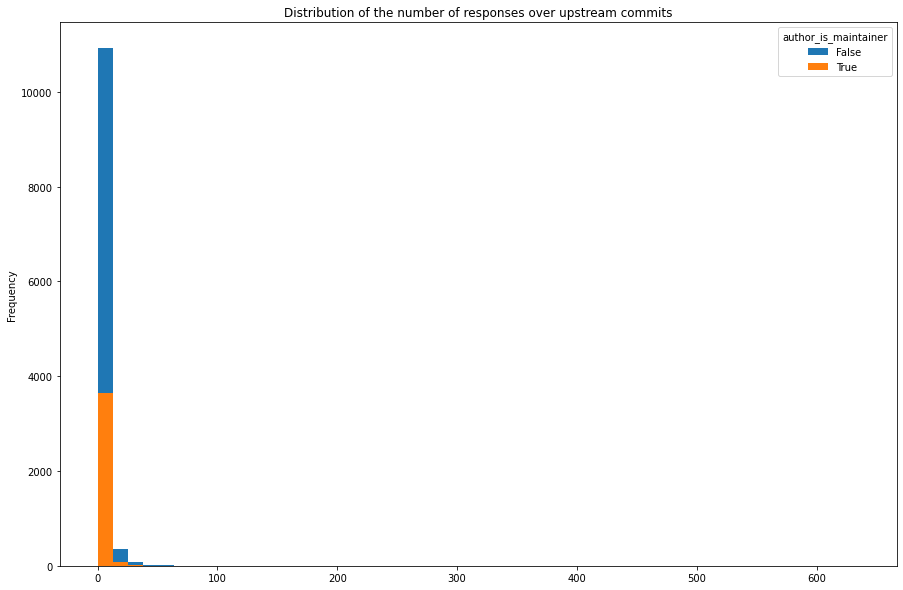

In [19]:
ax = patch_responses.groupby(['upstream', 'author_is_maintainer'])\
                    .nunique()['responses.resp_msg_id']\
                    .unstack()\
                    .plot.hist(figsize=(15,10), bins=50)

ax.set_title('Distribution of the number of responses over upstream commits')

ax.figure.savefig('dist_num_responses.pdf', bbox_inches = "tight")